<h1>Final Assignment: Honours-engineering+, Statistics course</h1>
<i>Maarten de Jeu</i>

This is my implementation for the Final Assignment for my statistics course. It requires performing a specific set of statistical tests (T-Test, ANOVA, Pearson's R, Linear Regression) on a dataset that I provide. Besides this, it's also expected that the document adheres to some more minor specifications, like the presence of graphs that are in some way useful.

The dataset I chose for this assignment is the wine review dataset as provided by <i>McQuire, 2022</i>. Specifically, I'm interested in differences in rating given to different wines according to certain features. I'll specifically be focussing on wines relevant to <i>an average Dutch consumer</i>, for as much as that means anything.


For any of the specified statistical tests, we set a required confidence of at least 95% to draw any conclusions from them.

In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
import seaborn as sns

from scipy import stats

In [205]:
df = pd.read_csv("wine.csv")
df.dtypes

wine           object
winery         object
category       object
designation    object
varietal       object
appellation    object
alcohol        object
price          object
rating          int64
reviewer       object
review         object
dtype: object

In [206]:
df.shape

(323237, 11)

When reading a CSV-file, Pandas attempts to convert all numeric columns to the proper datatype. Whenever these are not formatted in a way Pandas is sure to correctly interpret, they are left as Strings. Some data-engineering in this regard is required, because not all columns have been interpreted as one would expect them to be. We'll start out with that.

<h2>DataType-Engineering</h2>

<h3>Numeric columns</h3>

Out of the columns expected to be numeric (alcohol, price and rating), only rating has been correctly identified as numeric. We'll examine what the values look like to get a better understanding of the required operations.

In [207]:
numeric_columns = ["alcohol", "price", "rating"]

In [208]:
df[numeric_columns].head(10)

,alcohol,price,rating
0,NaN,$32,87
1,15%,$17,85
2,NaN,NaN,90
3,13.5%,$18,86
4,13.5%,$21,85
5,15.1%,$40,89
6,15.1%,$60,92
7,12%,$19,88
8,13%,$16,87
9,13.5%,$30,89


Rating has already been identified correctly as Integer. We'll work through the other 2, one at a time, to fix them as well.

<h4>Alcohol</h4>

Alcohol has some NaN values where the data is missing in the dataset. Besides those, everything is formatted as a floating-point number with '%' as suffix. We can fix this by applying a simple string-formatting function to the entire columns, and then converting to floating points numbers. Before doing this however, we'll note how many missing values there are, to make sure we don't accidentally lose more data through wrong assumptions about string formatting. These missing values are interpreted as the float datatype, which we should make sure not to affect with our string formatting function.

In [209]:
f"There are {df['alcohol'].isna().sum()} missing values in the alcohol column."

'There are 41021 missing values in the alcohol column.'

In [210]:
df["new alcohol"] = df["alcohol"].map(
    lambda string: string.strip("%"),
    na_action="ignore"
)

df["new alcohol"] = pd.to_numeric(df["new alcohol"])

In [211]:
f"There are {df['new alcohol'].isna().sum()} missing values in the new alcohol column."

'There are 41021 missing values in the new alcohol column.'

The same amount of values remain, and we've successfully converted the column to floating-point numbers. We'll overwrite the old alcohol column, and drop the new one, so we can move on to the next column.

In [212]:
df["alcohol"] = df["new alcohol"]
df.drop(columns="new alcohol", inplace=True)

<h4>Price</h4>

From our initial look at a subset of values in the numeric columns, it appears the steps that need to be taken to correct the datatype of the price column are similar to the steps we took with the alcohol column. This time, we have a '$' prefix instead.

In [213]:
f"There are {df['price'].isna().sum()} missing values in the price column."

'There are 23955 missing values in the price column.'

In [214]:
df["new price"] = df["price"].map(
    lambda string: string.strip("$"),
    na_action="ignore"
)

df["new price"] = pd.to_numeric(df["new price"], errors="coerce")

In [215]:
f"There are {df['new price'].isna().sum()} missing values in the new price column."

'There are 31199 missing values in the new price column.'

It appears we did lose some data in this conversion. Considering there are 300.000+ records in the dataset, this reduction of sample-size is not catastrophic. Still, let's see if we can get some insight into the lost values. To do this, we'll view a subset of the dataset where values are NaN in the new column, but where not NaN in the old column.

In [216]:
price_not_formatted = df[df["new price"].isna() & df["price"].notna()]

In [217]:
price_not_formatted["price"].value_counts()

VivinoGary's Wine                            3024
VivinoWine.com                               1586
DrizlyVivino                                 1165
VivinoWine Express                            280
VivinoGary's WineTotal Wine                   204
                                             ... 
Wine.comVivinoGary's Wine                       1
VivinoTotal WineWine ExpressWine.com            1
DrizlyVivinoTotal WineWine.com                  1
VivinoGary's WineTotal WineWired for Wine       1
Total WineParcelle                              1
Name: price, Length: 83, dtype: int64

These are clearly not useful prices, that could ever be converted to prices. We can replace the old price column with the new one, drop the new one, and drop mark the dataframe we just created for garbage collection.

In [218]:
df["price"] = df["new price"]
df.drop(columns="new price", inplace=True)
price_not_formatted = None  # Make DataFrame go out of scope, so that garbage collector cleans it up.

We have corrected the incorrect Data Types in the numeric columns, so now we can move on to the other columns.

<h3>Categorical Variables</h3>

Some of the categorical variables need some work as well. We'll print out the data once more to gain some insight.

In [219]:
df.head(5)

,wine,winery,category,designation,varietal,appellation,alcohol,price,rating,reviewer,review
0,J. Lohr 2000 Hilltop Vineyard Cabernet Sauvign...,J. Lohr,Red,Hilltop Vineyard,Cabernet Sauvignon,"Paso Robles, Central Coast, California, US",NaN,32.0,87,NaN,"Held back nearly five years, this Cab still ha..."
1,Antucura 2010 Pinot Noir (Vista Flores),Antucura,Red,NaN,Pinot Noir,"Vista Flores, Mendoza Province, Argentina",15.0,17.0,85,Michael Schachner,"Rubbery, bold and earthy on the nose, then ful..."
2,Quinta do Portal 1999 Quinta do Portal Reserva...,Quinta do Portal,Red,Quinta do Portal Reserva,"Red Blends, Red Blends","Douro, Portugal",NaN,NaN,90,Roger Voss,"Smoky, meaty aromas lead into perfumed fruit f..."
3,Tenuta di Ghizzano 2006 Il Ghizzano Red (Toscana),Tenuta di Ghizzano,Red,Il Ghizzano,"Red Blends, Red Blends","Toscana, Tuscany, Italy",13.5,18.0,86,NaN,The nose is rather neutral save for distant ar...
4,Tenuta San Francesco 2007 Tramonti White (Camp...,Tenuta San Francesco,White,Tramonti,White Blend,"Campania, Southern Italy, Italy",13.5,21.0,85,NaN,"This intriguing blend of Falanghina, Biancolel..."


There are some variables that are absolutely not useful in any way for the questions we're trying to answer, like the review text, and the wine's title. We can safely remove these from the dataset.

In [220]:
df.drop(
    columns=["wine", "review"],
    inplace=True
)

The other columns can be interpreted as categorical variables. To improve readability, we can mark these columns as categories.

In [221]:
categorical_columns = ["winery", "category", "designation", "varietal", "appellation", "reviewer"]

In [222]:
df[categorical_columns] = df[categorical_columns].astype("category")
df.dtypes

winery         category
category       category
designation    category
varietal       category
appellation    category
alcohol         float64
price           float64
rating            int64
reviewer       category
dtype: object

That's all the datatypes taken care of.

<h2>Outliers</h2>

The numerical columns could very well contain outliers. We can get a sense of these through boxplots.



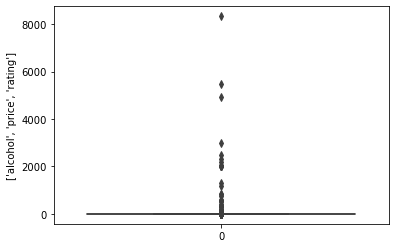

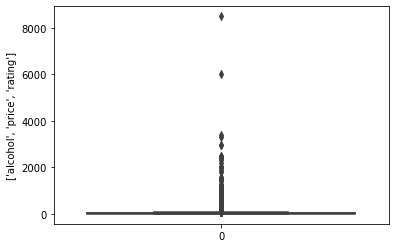

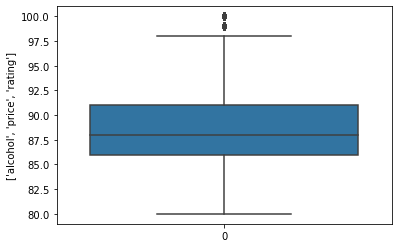

In [223]:
for col in numeric_columns:
    p = sns.boxplot(data=df[col])
    p.set_ylabel(numeric_columns)
    plt.show()

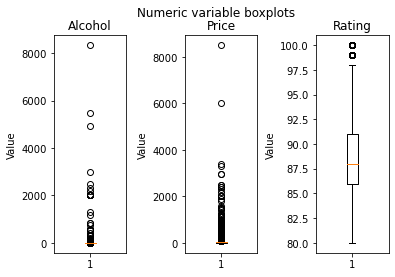

In [224]:
fig = plt.figure()
fig.subplots_adjust(wspace=.8)
fig.suptitle("Numeric variable boxplots")

for i, col in enumerate(numeric_columns):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.boxplot(df.loc[df[col].notna(), col])
    ax.set_ylabel("Value")
    ax.set_title(col.capitalize())


Alcohol and price appear to have some significant outliers. We can take care of those individually.

<h4>Alcohol</h4>

It's a fact of nature that a liquid can't have an alcohol percentage higher then 100%. We can go even lower by specifying our definition of wine. In the Netherlands, the highest permitted alcohol percentage for wine is set at 18.0%, with a lower limit for some categories. We'll remove any wines that violate that constraint.

The mininum amount of alcohol that a wine should have, to be called a wine in the Netherlands, is 1.2%, according to <i>Belastingdienst, 2020</i>. We can also remove any wines that violate that law.

In [225]:
df["alcohol"] = df.loc[((df["alcohol"] <= 18) & (df["alcohol"] >= 1.2)), "alcohol"]


<h4>Price</h4>

As one might expect, even though the bulk of wine seems to be in the price range of what most consumers would consider 'reasonable', there are some very expensive exceptions. We're interested most in the types of wines that a more average consumer would consume on a more regular basis, then in wines that would be considered 'luxury'. It's hard to base a limit of what to exclude on non-statistical information, considering what a person considers luxury is very much a cultural and personal thing. Therefore, we'll set the limit of what to exclude as at least 3 inter-quartile ranges away from both q1 and q3, considering this is quite a common definition of 'extreme outliers'. #TODO(m-jeu): Bron.

In [226]:
q1 = df["price"].quantile(.25)
q3 = df["price"].quantile(.75)

iqr3 = (q3 - q1) * 3
df["price"] = df.loc[
    ((df["price"] < q3 + iqr3) & (df["price"] > q1 - iqr3)),
    "price"
]

We've remove the outliers, now we can move on.

<h2>Distributions</h2>

Having removed the outliers, we can have a look at the exact distributions through histograms.

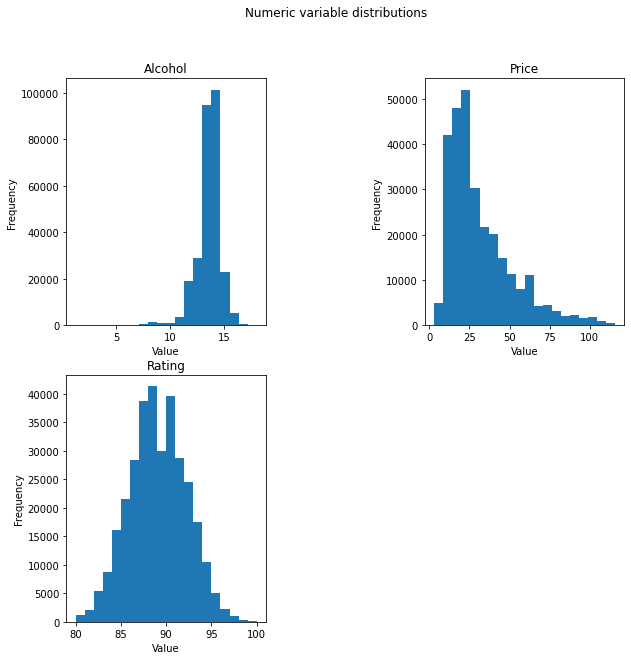

In [227]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(wspace=.8)
fig.suptitle("Numeric variable distributions")

for i, col in enumerate(numeric_columns):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.hist(df.loc[df[col].notna(), col], bins=20)
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Value")
    ax.set_title(col.capitalize())


Rating appears normally distributed. Price appears to be log normally distributed, but would require further testing. Alcohol's distribution is hard to gauge, because we permitted outliers far from the centre to remain in the sample. We can zoom in, to allow us to see the distribution more clearly.

Text(0.5, 1.0, 'Frequency of alcohol measurements, zoomed in to centre of distribution')

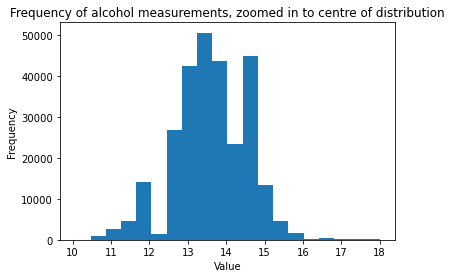

In [228]:
plt.hist(df.loc[df["alcohol"] > 10, "alcohol"], bins=20)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Frequency of alcohol measurements, zoomed in to centre of distribution")

Alcohol percentage also appears like it potentially could be normally distributed, but would require more looking into as well. Considering the size of the sample (300.000+) would, to my knowledge, break most normality tests. And considering the fact that the parametric statistical tests that the assignment expects me to use (ANOVA, T-Test) don't require normally distributed data for large sample sizes according to Ghasemi, A., &#38; Zahediasl, S. (2012), we don't need to perform any normality testing on the data.

<h2>Hypotheses and tests</h2>

Having engineered and examined in a more general sense, we can start working towards the specific hypotheses and tests.

<h3>ANOVA: Wine Categories</h3>

The first thing I'm interested in examining is the difference in rating between different types of wines. We have the following categories in our dataset:

In [229]:
df["category"].value_counts()

Red            194396
White           95424
Sparkling       14938
Rose            11667
Dessert          4329
Port/Sherry      2257
Fortified         226
Name: category, dtype: int64

We'll leave Port/Sherry out of scope, because parts of those are categories that already lost quite some wines by excluding based on alcohol percentage. We'll also exclude dessert wine, because the line between dessert wine and other types of wine is less distinct then between some of the categories that remain.

That means, specifically, we'll be testing the hypothesis <b>There's a statistically significant difference between the mean ratings of red wine, white wine, sparkling wine and rose</b>. The perfect test for this is the One-Way ANOVA test.

In [230]:
anova_cats = ["Red", "White", "Sparkling", "Rose"]
anova_data = [df.loc[df["category"] == cat, "rating"] for cat in anova_cats]

f_stat, p_anova = stats.f_oneway(anova_data[0], anova_data[1], anova_data[2], anova_data[3])

In [231]:
f_stat

1590.528595614146

In [232]:
p_anova

0.0

The ANOVA-test shows F = 1590, P < .0001. A 0% probability of anything sounds ridiculous when one takes the entropy of the universe into consideration, but we can interpret this as a probability so small that Python won't show us what the number actually is. With this, we can reject the null hypothesis "There is no statistically significant difference between the means of the different groups" and accept the alternative hypothesis we specified earlier.

We can also look at the actual values of the means to gain some more insight.

In [233]:
for name, data in zip(anova_cats, anova_data):
    print(f"{name} has a mean of {np.average(data)}.")

Red has a mean of 88.80213070227782.
White has a mean of 88.21433811200536.
Sparkling has a mean of 88.67358414781096.
Rose has a mean of 87.11528242050227.


As it turns out, the statistically significant difference we detected is not terribly big. Still, it could be interesting.

<h3>T-test: 2 types of grapes</h3>

I don't quite find the small differences between means of rating per category we examined earlier quite interesting enough to zoom into any specific combination through a t-test. Therefore, we'll examine the difference between mean rating for 2 types of popular white wine grape: "Sauvignon Blanc" and "Chardonnay".

We'll be examining the hypothesis <b>there's a statistically significant difference between the mean ratings of Sauvignon Blanc and Chardonnay</b>. We can test this using an independent T-Test.

In [234]:
tcats = ["Sauvignon Blanc", "Chardonnay"]
tdata = [df.loc[df["varietal"] == cat, "rating"] for cat in tcats]
stats.ttest_ind(tdata[0], tdata[1])

Ttest_indResult(statistic=-27.58980780866051, pvalue=4.5441493446522265e-166)

t = -28, P < .001, which is lower then our specified threshold of .05. This allows us to reject the null hypothesis "there's no statistically significant difference between the mean ratings of Sauvignon Blanc and Chardonnay" and accept the alternative hypothesis we specified earlier.

In [235]:
for name, data in zip(tcats, tdata):
    print(f"{name} has a mean of {np.average(data)}.")

Sauvignon Blanc has a mean of 87.48776561493882.
Chardonnay has a mean of 88.43279323346582.


Again, although it's statistically significant, the difference in means in not terribly big.

<h3>Pearson's R: Correlation with rating.</h3>

Next, and interesting this to examine would be using other numeric columns to predict rating. A good first step would be using Pearson's R to examine any potential linear correlations between rating and any other variables. The hypothesis we formulate for this is <b>There's a linear correlation (at least r > 0.4) between rating and another numeric variable</b>.

In [236]:
df[numeric_columns].corr()["rating"]

alcohol    0.154296
price      0.554115
rating     1.000000
Name: rating, dtype: float64

We can see that price has a medium-strength positive correlation with rating (r = 0.55). Alcohol doesn't really correlate with rating (r = 0.15).

<h3>Linear Regression and R-Squared: Predicting Rating</h3>

Knowing price and rating correlate at least modestly, we can use this information to attempt to predict a wine's rating using price. A good data-scientist might split the data into a test and a training set, before constructing this model, but considering we're working with more then 300.000 data-points and 2 degrees of freedom for linear regression, I personally don't consider the risk for over-fitting to be that big.

We'll drop any missing data we removed in the Data-Engineering chapter and use this to construct a Linear regression model. Then we'll score it using the r-squared metric.

In [237]:
df_numeric = df[numeric_columns].dropna()

In [238]:
price_transformed = df_numeric["price"].to_numpy().reshape((-1, 1))

In [239]:
model_2d = linear_model.LinearRegression()
model_2d.fit(price_transformed, df_numeric["rating"])
model_2d.score(price_transformed, df_numeric["rating"])

0.3096350837027201

Our model has an r-squared score of 0.31, which means our model explains approximately 31% of the variation in rating. Which could be a useful model, and is quite interesting! We can look at this relationship visually through a scatterplot.

Text(0.5, 1.0, 'Price/Rating scatter plot')

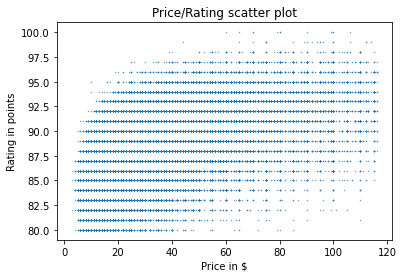

In [240]:
plt.scatter(df_numeric["price"], df_numeric["rating"], s=0.1, alpha=.99)
plt.xlabel("Price in $")
plt.ylabel("Rating in points")
plt.title("Price/Rating scatter plot")

<h2>References</h2>

Belastingdienst. (2020, 6 juni). Alcoholpercentage, volume en verrijking. belastingdienst.nl. Retrieved January 24, 2022, van https://www.belastingdienst.nl/bibliotheek/handboeken/html/boeken/HA/wijn-alcoholpercentage_volume_en_verrijking.html

McGuire, S. A. (2022, January 24). Samueladamsmcguire/wine_data_clean: Transformation of scraped HTML to organized pandas dataframe. GitHub. Retrieved January 24, 2022, from https://github.com/SamuelAdamsMcGuire/wine_data_clean

Ghasemi, A., &#38; Zahediasl, S. (2012). Normality Tests for Statistical Analysis: A Guide for Non-Statisticians. <i>International Journal of Endocrinology and Metabolism</i>, <i>10</i>(2), 486–489. https://doi.org/10.5812/ijem.3505